In [1]:
'''
Evaluate trained PredNet on KITTI sequences.
Calculates mean-squared error and plots predictions.
'''

import os
import cv2
import numpy as np
from six.moves import cPickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from keras import backend as K
from keras.models import Model, model_from_json
from keras.layers import Input, Dense, Flatten, UpSampling3D

from prednet import PredNet
from data_utils import SequenceGenerator
from kitti_settings import *

os.environ['KMP_DUPLICATE_LIB_OK']='True'

n_plot = 40
batch_size = 10
nt = 1

weights_file = os.path.join(WEIGHTS_DIR, 'tensorflow_weights/prednet_kitti_weights.hdf5')
json_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_model.json')
test_file = os.path.join(DATA_DIR, 'X_test.hkl')
test_sources = os.path.join(DATA_DIR, 'sources_test.hkl')

# Load trained model
f = open(json_file, 'r')
json_string = f.read()
f.close()
train_model = model_from_json(json_string, custom_objects = {'PredNet': PredNet})
train_model.load_weights(weights_file)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
# Create testing model (to output predictions)
layer_config = train_model.layers[1].get_config()
#layer_config['output_mode'] = 'prediction'
layer_config['output_mode'] = 'R0'
data_format = layer_config['data_format'] if 'data_format' in layer_config else layer_config['dim_ordering']
test_prednet = PredNet(weights=train_model.layers[1].get_weights(), **layer_config)
#input_shape = list(train_model.layers[0].batch_input_shape[1:])


In [3]:
input_shape = list(train_model.layers[0].batch_input_shape[1:])
input_shape[0] = nt
inputs = Input(shape=tuple(input_shape))
#inputs = Input(shape = (1,3,128,160))    # dim_1, channels, dim_2, dim_3
copied_inputs = UpSampling3D(size = (10,1,1), data_format="channels_last")(inputs)

In [4]:
train_model.layers[1].get_config()

{'name': 'prednet_1',
 'trainable': True,
 'batch_input_shape': (None, None, None),
 'dtype': 'float32',
 'return_sequences': True,
 'return_state': False,
 'go_backwards': False,
 'stateful': False,
 'unroll': False,
 'implementation': 0,
 'stack_sizes': [3, 48, 96, 192],
 'R_stack_sizes': [3, 48, 96, 192],
 'A_filt_sizes': [3, 3, 3],
 'Ahat_filt_sizes': [3, 3, 3, 3],
 'R_filt_sizes': [3, 3, 3, 3],
 'pixel_max': 1.0,
 'error_activation': 'relu',
 'A_activation': 'relu',
 'LSTM_activation': 'tanh',
 'LSTM_inner_activation': 'hard_sigmoid',
 'data_format': 'channels_first',
 'extrap_start_time': None,
 'output_mode': 'error'}

In [5]:
predictions = test_prednet(copied_inputs)
test_model = Model(inputs=inputs, outputs=predictions)

In [6]:
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 3, 128, 160)    0         
_________________________________________________________________
up_sampling3d_1 (UpSampling3 (None, 10, 3, 128, 160)   0         
_________________________________________________________________
prednet_1 (PredNet)          (None, 10, 3, 128.0, 160. 6915948   
Total params: 6,915,948
Trainable params: 6,915,948
Non-trainable params: 0
_________________________________________________________________


In [152]:
from keras.utils.vis_utils import plot_model

In [153]:
plot_model(test_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [8]:
def convert_to_display_format(batched_input,k):
    disp = np.transpose(batched_input[0,k,:,:,:],(1,2,0))
    return disp

### first we load for the illusion image

In [272]:
im = cv2.imread("Test_data_illusion_single_L.jpg",-1)
#type(im)
b,g,r = cv2.split(im)
im2 = cv2.merge([r,g,b])
newim = np.pad(im2,((0,8),(0,0),(0,0)), 'constant',constant_values=(255))
newim = newim/255.0
newima = np.resize(newim,(1,1,128,160,3))
newim2 = np.transpose(newima,(0,1,4,2,3))
#X_ill_norm = (X_ill[0,9] - np.min(X_ill[0,9]))/np.ptp(X_ill[0,9])

### then we load the non-illusion image

In [271]:
imn = cv2.imread("Test_data_non_illusion_single.jpg",-1)
#type(im)
b,g,r = cv2.split(imn)
im2n = cv2.merge([r,g,b])
newimn = np.pad(im2n,((0,8),(0,0),(0,0)), 'constant',constant_values=(255))
newimn = newimn/255.0
newiman = np.resize(newimn,(1,1,128,160,3))
newim2n = np.transpose(newiman,(0,1,4,2,3))
#X_ill_norm = (X_ill[0,9] - np.min(X_ill[0,9]))/np.ptp(X_ill[0,9])

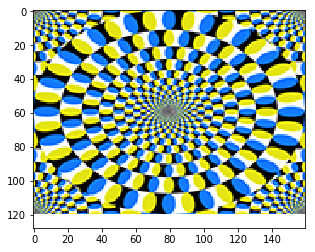

In [93]:
plt.imshow(newim)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


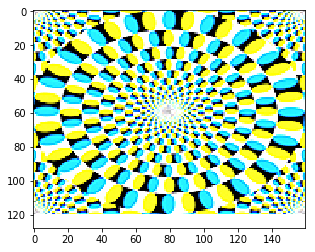

In [212]:
plt.imshow(newim*2.)

In [209]:
np.max(newim*2.)

2.0

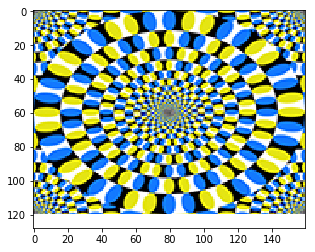

In [99]:
plt.imshow(newimn)

### we now go through the various rrecurrence layers and compare the activation of the two images

#### The first recurrence layer r0

In [11]:
layer_config['output_mode'] = 'R0'
test_prednet = PredNet(weights=train_model.layers[1].get_weights(), **layer_config)
test_model = Model(inputs=inputs, outputs=predictions)
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 3, 128, 160)    0         
_________________________________________________________________
up_sampling3d_1 (UpSampling3 (None, 10, 3, 128, 160)   0         
_________________________________________________________________
prednet_1 (PredNet)          (None, 10, 3, 128.0, 160. 6915948   
Total params: 6,915,948
Trainable params: 6,915,948
Non-trainable params: 0
_________________________________________________________________


AttributeError: 'PredNet' object has no attribute 'layers'

In [12]:
X_ill = test_model.predict([newim2], batch_size)
X_nill = test_model.predict([newim2n], batch_size)

In [204]:
np.min(X_ill + 1.)

0.17459208

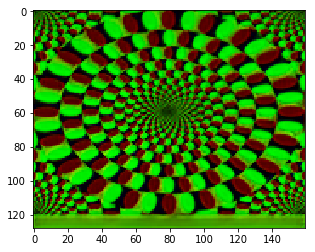

In [32]:
plt.imshow(convert_to_display_format(np.minimum(np.maximum(X_ill,0.0),1.0),9))

TypeError: data type not understood

In [107]:
test_prednet.conv_layers['ahat'][0].call(X_ill)

AttributeError: 'numpy.dtype' object has no attribute 'base_dtype'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


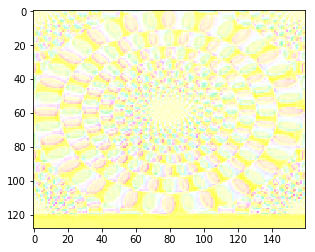

In [91]:
plt.imshow(convert_to_display_format(X_ill+1.,9))

In [30]:
np.min(np.maximum(X_ill,0))

0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


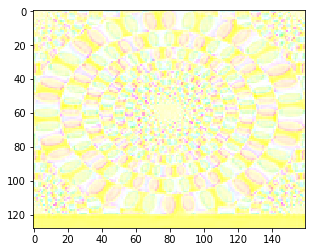

In [197]:
plt.imshow(convert_to_display_format(X_nill,9)+1.)

#### The second hidden recurrence layer R1

In [157]:
layer_config['output_mode'] = 'R1'
test_prednet = PredNet(weights=train_model.layers[1].get_weights(), **layer_config)
copied_inputs = UpSampling3D(size = (20,1,1), data_format="channels_last")(inputs)
predictions = test_prednet(copied_inputs)
test_model = Model(inputs=inputs, outputs=predictions)
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 3, 128, 160)    0         
_________________________________________________________________
up_sampling3d_2 (UpSampling3 (None, 20, 3, 128, 160)   0         
_________________________________________________________________
prednet_1 (PredNet)          (None, 20, 48, 64.0, 80.0 6915948   
Total params: 6,915,948
Trainable params: 6,915,948
Non-trainable params: 0
_________________________________________________________________


In [163]:
X_ill1 = test_model.predict([newim2], batch_size)
X_nill1 = test_model.predict([newim2n], batch_size)

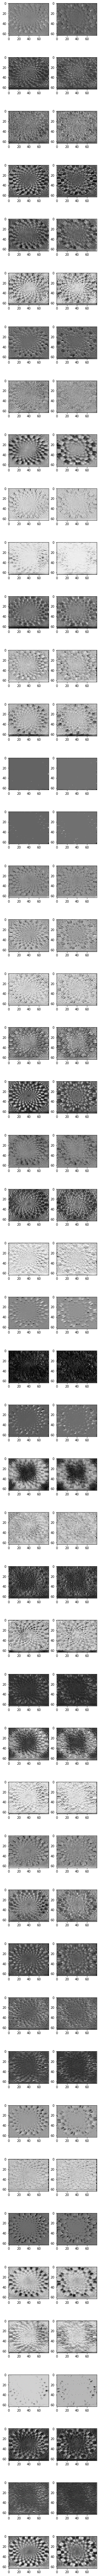

In [165]:
plt.figure(figsize=(5,150))
rows = X_ill1.shape[2]
cols = 2
for i in range(X_ill1.shape[2]):    
    plt.subplot(rows,cols,2*(i+1)-1)
    plt.imshow(X_ill1[0,19,i], cmap="gray")
    plt.subplot(rows,cols,2*(i+1))
    plt.imshow(X_nill1[0,19,i], cmap="gray")
    
plt.show()    

### The third hidden recurrence layer R2

In [166]:
layer_config['output_mode'] = 'R2'
test_prednet = PredNet(weights=train_model.layers[1].get_weights(), **layer_config)
predictions = test_prednet(copied_inputs)
test_model = Model(inputs=inputs, outputs=predictions)
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 3, 128, 160)    0         
_________________________________________________________________
up_sampling3d_2 (UpSampling3 (None, 20, 3, 128, 160)   0         
_________________________________________________________________
prednet_1 (PredNet)          (None, 20, 96, 32.0, 40.0 6915948   
Total params: 6,915,948
Trainable params: 6,915,948
Non-trainable params: 0
_________________________________________________________________


In [167]:
X_ill2 = test_model.predict([newim2], batch_size)
X_nill2 = test_model.predict([newim2n], batch_size)

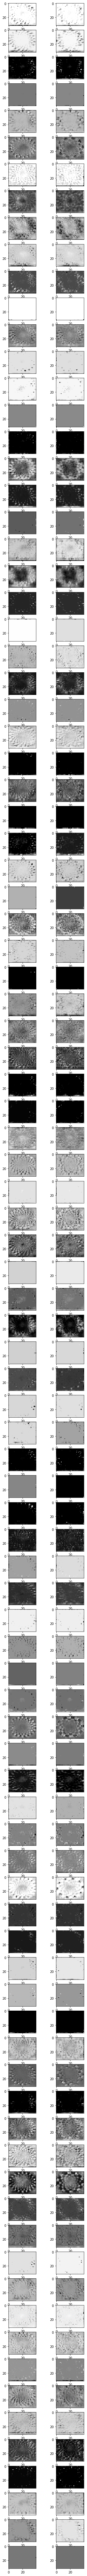

In [168]:
plt.figure(figsize=(5,150))
rows = X_ill2.shape[2]
cols = 2
for i in range(X_ill2.shape[2]):    
    plt.subplot(rows,cols,2*(i+1)-1)
    plt.imshow(X_ill2[0,19,i], cmap="gray")
    plt.subplot(rows,cols,2*(i+1))
    plt.imshow(X_nill2[0,19,i], cmap="gray")
    
plt.show()    

### lets check for non-circular motion

In [192]:
im = cv2.imread("rollers.jpg",-1)
b,g,r = cv2.split(im)
im2 = cv2.merge([r,g,b])
#newim = np.pad(im2,((0,8),(0,0),(0,0)), 'constant',constant_values=(255))
newim = im2/255.0
newima = cv2.resize(newim,(160,128),interpolation= cv2.INTER_AREA)
newiman = np.resize(newima,(1,1,128,160,3))
newim2roll = np.transpose(newiman,(0,1,4,2,3))
#X_ill_norm = (X_ill[0,9] - np.min(X_ill[0,9]))/np.ptp(X_ill[0,9])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


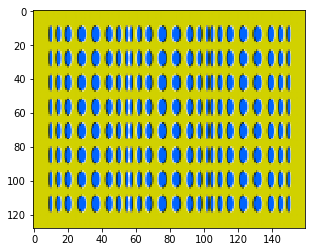

In [61]:
plt.imshow(newima)

In [65]:
layer_config['output_mode'] = 'prediction'
test_prednet = PredNet(weights=train_model.layers[1].get_weights(), **layer_config)
predictions = test_prednet(copied_inputs)
test_model = Model(inputs=inputs, outputs=predictions)
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 3, 128, 160)    0         
_________________________________________________________________
up_sampling3d_1 (UpSampling3 (None, 10, 3, 128, 160)   0         
_________________________________________________________________
prednet_1 (PredNet)          (None, 10, 3, 128, 160)   6915948   
Total params: 6,915,948
Trainable params: 6,915,948
Non-trainable params: 0
_________________________________________________________________


In [66]:
X_roll = test_model.predict([newim2], batch_size)

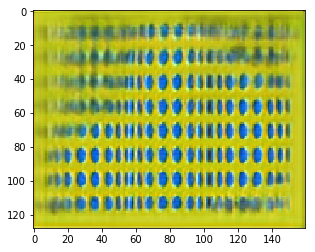

In [82]:
plt.imshow(convert_to_display_format(X_roll,9))

### R0

In [ ]:
layer_config['output_mode'] = 'R0'
test_prednet = PredNet(weights=train_model.layers[1].get_weights(), **layer_config)
predictions = test_prednet(copied_inputs)
test_model = Model(inputs=inputs, outputs=predictions)
test_model.summary()

In [71]:
X_roll0 = test_model.predict([newim2], batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


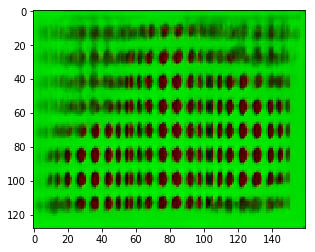

In [72]:
plt.imshow(convert_to_display_format(X_roll0,9))

### R1

In [83]:
layer_config['output_mode'] = 'R1'
test_prednet = PredNet(weights=train_model.layers[1].get_weights(), **layer_config)
predictions = test_prednet(copied_inputs)
test_model = Model(inputs=inputs, outputs=predictions)
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 3, 128, 160)    0         
_________________________________________________________________
up_sampling3d_1 (UpSampling3 (None, 10, 3, 128, 160)   0         
_________________________________________________________________
prednet_1 (PredNet)          (None, 10, 48, 64.0, 80.0 6915948   
Total params: 6,915,948
Trainable params: 6,915,948
Non-trainable params: 0
_________________________________________________________________


In [84]:
X_roll1 = test_model.predict([newim2], batch_size)

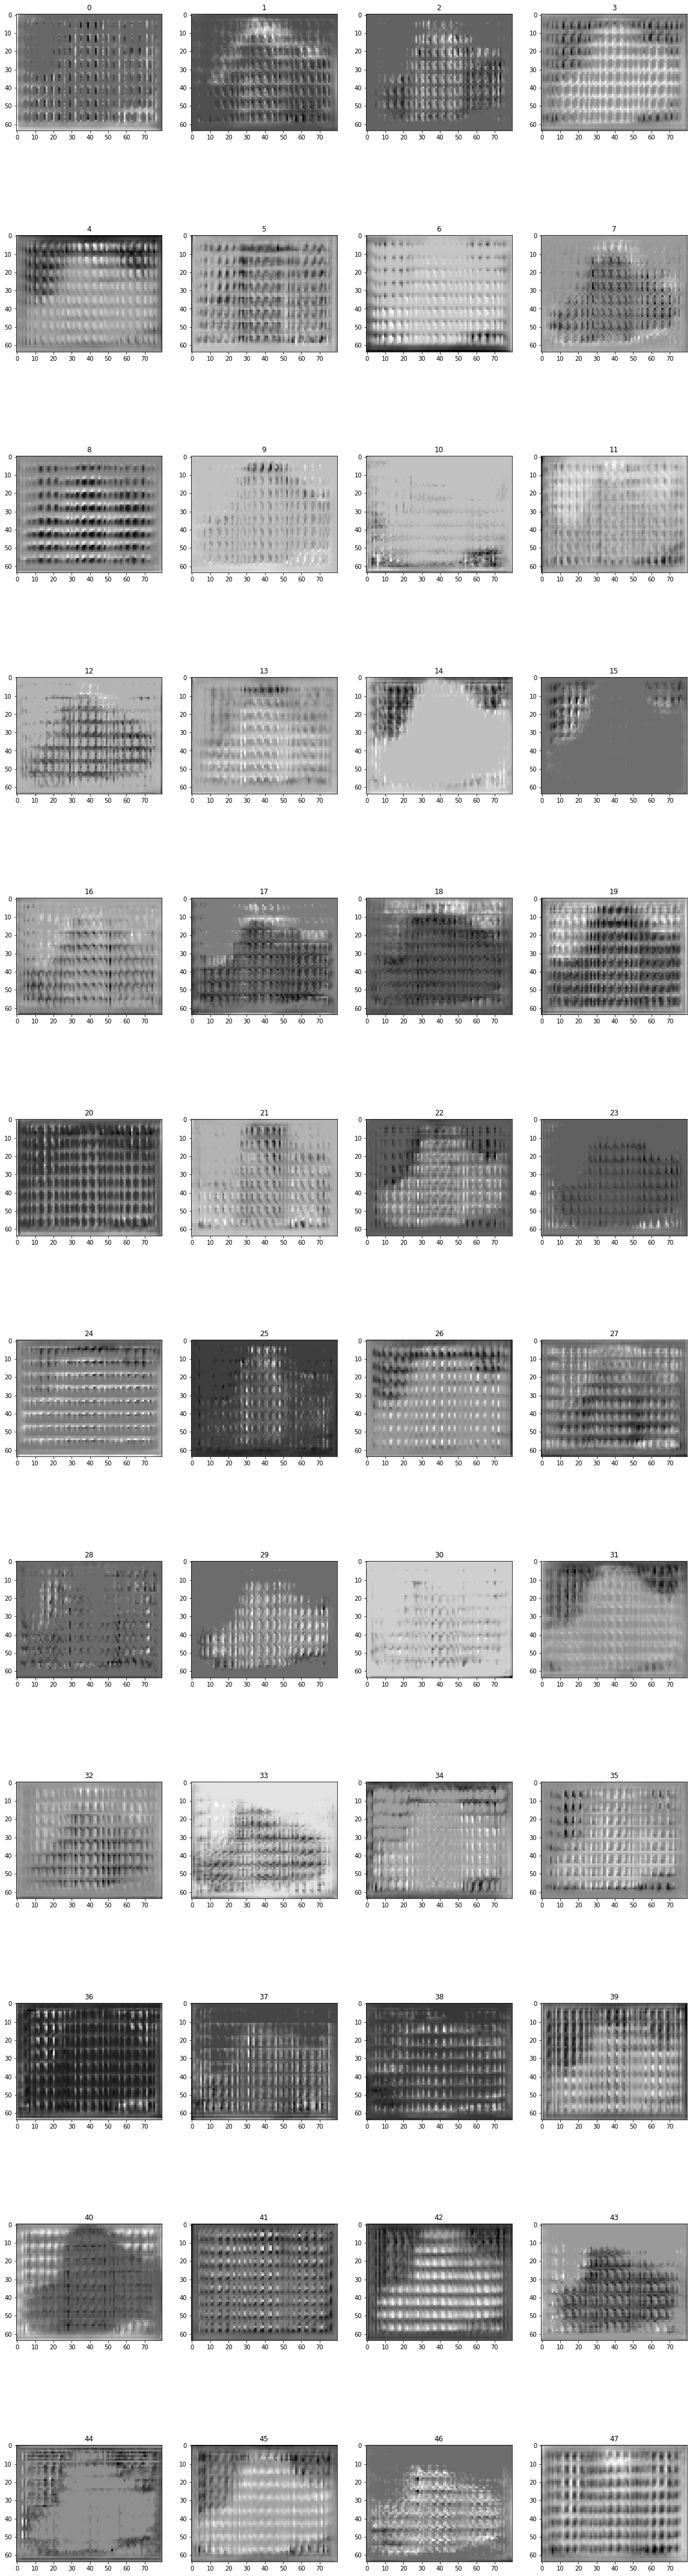

In [156]:
plt.figure(figsize=(20,80))
rows = X_roll1.shape[2]/4
cols = 4
for i in range(X_roll1.shape[2]):    
    plt.subplot(rows,cols,i+1)
    plt.title(str(i))
    plt.imshow(X_roll1[0,9,i], cmap="gray")
    
plt.show()  

## Here we want to compare the activation of the fourth error layer, comparing street image, non-illusion and illusion.

In [169]:
# Create testing image
test_generator = SequenceGenerator(test_file, test_sources, nt, sequence_start_mode='unique', data_format=data_format)
X_test = test_generator.create_all()
init_image = X_test[0:1]

#if data_format == 'channels_first':
#    X_test = np.transpose(X_test, (0, 1, 3, 4, 2))
#    X_hat = np.transpose(X_hat, (0, 1, 3, 4, 2))

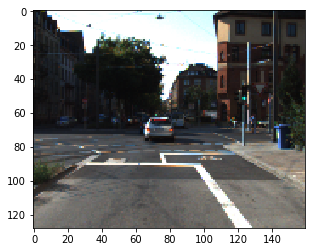

In [206]:
plt.imshow(convert_to_display_format(init_image,0))

In [180]:
layer_config['output_mode'] = 'error'
test_prednet = PredNet(weights=train_model.layers[1].get_weights(), **layer_config)
copied_inputs = UpSampling3D(size = (20,1,1), data_format="channels_last")(inputs)
predictions = test_prednet(copied_inputs)
test_model = Model(inputs=inputs, outputs=predictions)
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 3, 128, 160)    0         
_________________________________________________________________
up_sampling3d_4 (UpSampling3 (None, 20, 3, 128, 160)   0         
_________________________________________________________________
prednet_1 (PredNet)          (None, 20, 4)             6915948   
Total params: 6,915,948
Trainable params: 6,915,948
Non-trainable params: 0
_________________________________________________________________


In [181]:
X_err_ill = test_model.predict([newim2], batch_size)
X_err_nill = test_model.predict([newim2n], batch_size)
X_err_street = test_model.predict([init_image], batch_size)

In [194]:
X_err_roller = test_model.predict([newim2roll], batch_size)

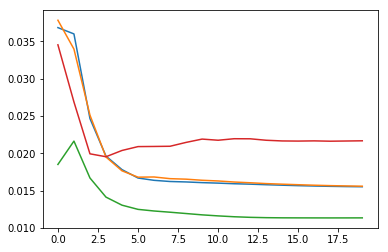

In [199]:
l = 3
plt.plot(X_err_ill[0,:,l]) #blue/orange
plt.plot(X_err_nill[0,:,l]) # blue/orange
plt.plot(X_err_street[0,:,l]) # green
plt.plot(X_err_roller[0,:,l]) # red
plt.show()

## Here we turn to gradient ascent. 

In [ ]:
# define a placeholder for the input image_vector (the flattened image)
input_img = test_model.input

#### Given the idea of predictive coding, we first attempt to maximize the average error in the highest layer, since that would correspond to the presence of non-natural features in the input image that the prednet is unable to accomodate even over many rounds.

In [205]:
# define the loss function - which is precisely just the mean of the probability of the given character across the batch
loss = K.mean(test_model.output[0,:,-1])

#compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

#normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

#this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

Instructions for updating:
Use tf.cast instead.


In [207]:
# run gradient ascent for n steps

#input_img_data = newim2
input_img_data = init_image
n = 100
step = 0.1
for i in range(n):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data = np.add(input_img_data,grads_value * step) #grads_value * step

    print('Current loss value:', loss_value)

Current loss value: 0.012934606
Current loss value: 0.014129716
Current loss value: 0.018217573
Current loss value: 0.023870993
Current loss value: 0.030861452
Current loss value: 0.03842471
Current loss value: 0.04676783
Current loss value: 0.05511435
Current loss value: 0.06222052
Current loss value: 0.071348146
Current loss value: 0.078477055
Current loss value: 0.08803842
Current loss value: 0.09572524
Current loss value: 0.10332414
Current loss value: 0.108934835
Current loss value: 0.11782613
Current loss value: 0.12513089
Current loss value: 0.13257961
Current loss value: 0.1382112
Current loss value: 0.14707728
Current loss value: 0.15432826
Current loss value: 0.16115147
Current loss value: 0.16972761
Current loss value: 0.17645052
Current loss value: 0.18285668
Current loss value: 0.19017397
Current loss value: 0.19952686
Current loss value: 0.20749268
Current loss value: 0.21523154
Current loss value: 0.21940298
Current loss value: 0.23039226
Current loss value: 0.2363402
Cu

In [226]:
ascent1 = input_img_data

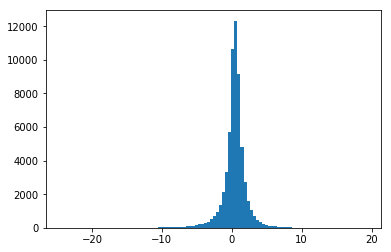

In [238]:
plt.hist(ascent1.flatten(),100)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


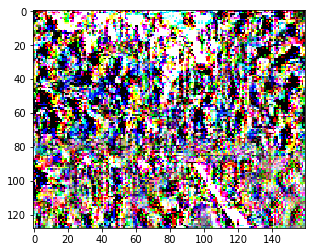

In [228]:
plt.imshow(convert_to_display_format(input_img_data,0))

### Next we try to have a bit of a regularization by also including an effect that the output image should have a small error at the first layer (instead of simply saying that the image should remain normalized). Requiring small error at the first layer is like saying that the input image shouldn't change too much.

In [231]:
lambda_0 = 1
lambda_3 = 1

# define the loss function - which is precisely just the mean of the probability of the given character across the batch
loss = lambda_3*K.mean(test_model.output[0,:,-1]) - lambda_0*K.mean(test_model.output[0,:,0])

#compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

#normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

#this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [232]:
# run gradient ascent for n steps

#input_img_data = newim2
input_img_data = init_image
n = 50
step = 0.1
for i in range(n):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data = np.add(input_img_data,grads_value * step) #grads_value * step

    print('Current loss value:', loss_value)

Current loss value: 0.0027227523
Current loss value: -0.005079857
Current loss value: -0.0030508786
Current loss value: -0.003018897
Current loss value: 0.001410719
Current loss value: 0.00422759
Current loss value: 0.0069809966
Current loss value: 0.010252245
Current loss value: 0.013096945
Current loss value: 0.01575607
Current loss value: 0.018505264
Current loss value: 0.022691455
Current loss value: 0.025727175
Current loss value: 0.027818535
Current loss value: 0.030205276
Current loss value: 0.03361614
Current loss value: 0.036929194
Current loss value: 0.040275034
Current loss value: 0.043704674
Current loss value: 0.04132251
Current loss value: 0.043781452
Current loss value: 0.04837122
Current loss value: 0.050703883
Current loss value: 0.054327454
Current loss value: 0.05707194
Current loss value: 0.059424743
Current loss value: 0.063265815
Current loss value: 0.06575931
Current loss value: 0.066328526
Current loss value: 0.06800334
Current loss value: 0.068323575
Current lo

In [233]:
ascent2 = input_img_data

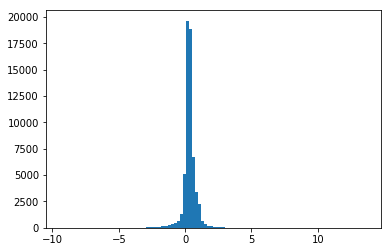

In [237]:
plt.hist(ascent2.flatten(),100)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


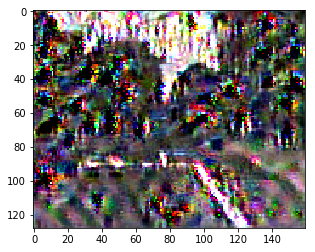

In [234]:
plt.imshow(convert_to_display_format(ascent2,0))

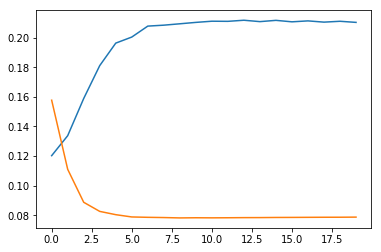

In [240]:
X_err_ascent2 = test_model.predict([ascent2], batch_size)
plt.plot(X_err_ascent2[0,:,3]) #blue
plt.plot(X_err_ascent2[0,:,0]) #blue/orange
plt.show()

### Next we add a "regularization" and also slightly change the prefactors (NB: regularization here is simply that at every step it is ensured that pixel values remain within 0. and 1.)

In [248]:
lambda_0 = 1
lambda_3 = 0.1
regul = 100

# define the loss function
loss = lambda_3*K.mean(test_model.output[0,:,-1]) - lambda_0*K.mean(test_model.output[0,:,0])

#compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

#normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

#this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [252]:
# run gradient ascent for n steps

#input_img_data = newim2
input_img_data = init_image
n = 50
step = 0.1
for i in range(n):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data = np.add(input_img_data,grads_value * step) #grads_value * step
    # here we add an artificial regularizer boundary...
    input_img_data = np.minimum(np.maximum(input_img_data,0.),1.)

    print('Current loss value:', loss_value)

Current loss value: -0.0089183925
Current loss value: -0.014912008
Current loss value: -0.015020189
Current loss value: -0.016872475
Current loss value: -0.014423331
Current loss value: -0.014793712
Current loss value: -0.013600308
Current loss value: -0.014055685
Current loss value: -0.013198371
Current loss value: -0.014128016
Current loss value: -0.0138039235
Current loss value: -0.013768597
Current loss value: -0.013011057
Current loss value: -0.014194647
Current loss value: -0.013115266
Current loss value: -0.013467591
Current loss value: -0.0128652835
Current loss value: -0.013705715
Current loss value: -0.012845098
Current loss value: -0.012921074
Current loss value: -0.013263912
Current loss value: -0.013338447
Current loss value: -0.012690407
Current loss value: -0.012547738
Current loss value: -0.013041833
Current loss value: -0.012930053
Current loss value: -0.012555176
Current loss value: -0.01241715
Current loss value: -0.012780982
Current loss value: -0.012629513
Current 

In [253]:
ascent3 = input_img_data

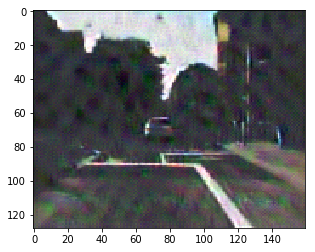

In [254]:
plt.imshow(convert_to_display_format(ascent3,0))

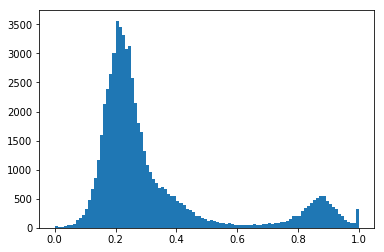

In [255]:
plt.hist(ascent3.flatten(),100)
plt.show()

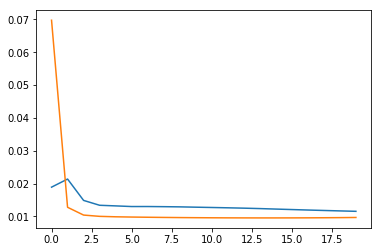

In [258]:
X_err_ascent3 = test_model.predict([ascent3], batch_size)
plt.plot(X_err_ascent3[0,:,3]) #blue
plt.plot(X_err_ascent3[0,:,0]) #blue/orange
plt.show()

In [213]:
X_asc = test_model.predict([input_img_data], batch_size)

### Try this again without the regularization, with only changing the parameters

In [259]:
lambda_0 = 1
lambda_3 = 0.1

# define the loss function
loss = lambda_3*K.mean(test_model.output[0,:,-1]) - lambda_0*K.mean(test_model.output[0,:,0])

#compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

#normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

#this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [260]:
# run gradient ascent for n steps

#input_img_data = newim2
input_img_data = init_image
n = 50
step = 0.1
for i in range(n):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data = np.add(input_img_data,grads_value * step) #grads_value * step
    # here we add an artificial regularizer boundary...
    #input_img_data = np.minimum(np.maximum(input_img_data,0.),1.)

    print('Current loss value:', loss_value)

Current loss value: -0.0089183925
Current loss value: -0.015151719
Current loss value: -0.016532993
Current loss value: -0.017473238
Current loss value: -0.015103667
Current loss value: -0.0147484355
Current loss value: -0.0141692115
Current loss value: -0.014490336
Current loss value: -0.013644309
Current loss value: -0.013868058
Current loss value: -0.014320343
Current loss value: -0.013973888
Current loss value: -0.013109058
Current loss value: -0.0145814195
Current loss value: -0.014015614
Current loss value: -0.0138128325
Current loss value: -0.012737216
Current loss value: -0.013705716
Current loss value: -0.013250739
Current loss value: -0.013402499
Current loss value: -0.0125000635
Current loss value: -0.013256796
Current loss value: -0.013062948
Current loss value: -0.013239771
Current loss value: -0.012391297
Current loss value: -0.01291122
Current loss value: -0.012872518
Current loss value: -0.01281329
Current loss value: -0.012368187
Current loss value: -0.012626275
Curren

In [261]:
ascent4 = input_img_data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


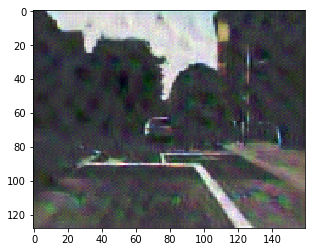

In [262]:
plt.imshow(convert_to_display_format(ascent4,0))

### now try a different layer

In [263]:
lambda_0 = 1
lambda_2 = 1

# define the loss function - which is precisely just the mean of the probability of the given character across the batch
loss = lambda_2*K.mean(test_model.output[0,:,2]) - lambda_0*K.mean(test_model.output[0,:,0])

#compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

#normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

#this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [264]:
# run gradient ascent for n steps

#input_img_data = newim2
input_img_data = init_image
n = 50
step = 0.1
for i in range(n):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data = np.add(input_img_data,grads_value * step) #grads_value * step
    # here we add an artificial regularizer boundary...
    #input_img_data = np.minimum(np.maximum(input_img_data,0.),1.)

    print('Current loss value:', loss_value)

Current loss value: 0.0040675
Current loss value: 0.00020883605
Current loss value: 0.0038365908
Current loss value: 0.0068752468
Current loss value: 0.01358919
Current loss value: 0.019748885
Current loss value: 0.025166394
Current loss value: 0.030250955
Current loss value: 0.034658477
Current loss value: 0.038121212
Current loss value: 0.042161815
Current loss value: 0.0447816
Current loss value: 0.047945898
Current loss value: 0.05054292
Current loss value: 0.054320034
Current loss value: 0.056346104
Current loss value: 0.0587664
Current loss value: 0.061405208
Current loss value: 0.0635445
Current loss value: 0.06617041
Current loss value: 0.06864804
Current loss value: 0.07082346
Current loss value: 0.073564634
Current loss value: 0.07593638
Current loss value: 0.07809794
Current loss value: 0.08007776
Current loss value: 0.08217889
Current loss value: 0.08472745
Current loss value: 0.087007076
Current loss value: 0.08808839
Current loss value: 0.09129742
Current loss value: 0.09

In [265]:
ascent_2_0 = input_img_data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


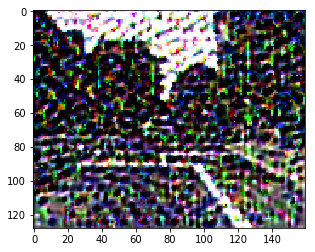

In [266]:
plt.imshow(convert_to_display_format(ascent_2_0,0))

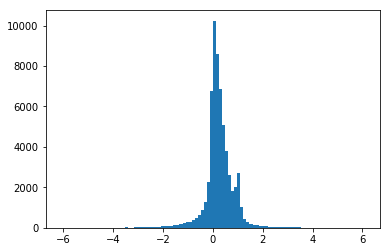

In [268]:
plt.hist(ascent_2_0.flatten(),100)
plt.show()

### intuitively, what I think we learn from this is that the strongest error responses are evoked by strong contrasts. The fact that the "cell" size becomes smaller is consistent with the convolutional window at the given layer.

### what I would want to do next is to look for fingerprints of movement/see how images react if I consider correlations between different features or even across layers (although one would have to rewrite the original prednet to allow for an output mode where all recurrence layer activations/error layer activations are provided at the same time.

In [270]:
layer_config['output_mode'] = 'E3'
test_prednet = PredNet(weights=train_model.layers[1].get_weights(), **layer_config)
copied_inputs = UpSampling3D(size = (10,1,1), data_format="channels_last")(inputs)
predictions = test_prednet(copied_inputs)
test_model = Model(inputs=inputs, outputs=predictions)
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 3, 128, 160)    0         
_________________________________________________________________
up_sampling3d_6 (UpSampling3 (None, 10, 3, 128, 160)   0         
_________________________________________________________________
prednet_1 (PredNet)          (None, 10, 384, 16.0, 20. 6915948   
Total params: 6,915,948
Trainable params: 6,915,948
Non-trainable params: 0
_________________________________________________________________


In [276]:
X_ill_errors_3 = test_model.predict([newim2], batch_size)
X_nill_errors_3 = test_model.predict([newim2n], batch_size)

In [351]:
def gram_tensor(x):
    a = K.reshape(x[0,-1],(x.shape[2],-1))
    return K.dot(a,K.transpose(a))

def gram(x):
    a = np.reshape(x[0,-1],(x.shape[2],-1))
    return np.dot(a,np.transpose(a))

In [367]:
gram_ill_errors_3 = gram_tensor(X_ill_errors_3)
gram_nill_errors_3 = gram(X_nill_errors_3)

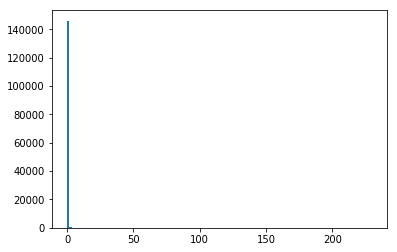

In [353]:
plt.hist(gram_ill_errors_3.flatten(),200)
plt.show()

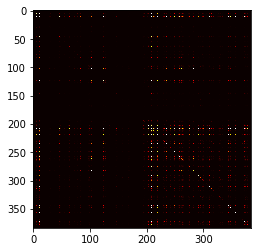

In [357]:
plt.imshow(gram_ill_errors_3, cmap='hot', vmax=4.0)
plt.show()

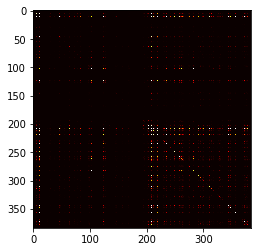

In [356]:
plt.imshow(gram_nill_errors_3, cmap='hot', vmax=4.0)
plt.show()

In [341]:
np.sum(gram_nill_errors_3)

74698.64

### First see what happens if we maximise the total sum of the entries of the gram matrix of the highest error layer (like the loss term in the style transfer paper)

In [326]:
# define the loss function - which is precisely just the mean of the probability of the given character across the batch
#loss = lambda_2*K.mean(test_model.output[0,:,3]) - lambda_0*K.mean(test_model.output[0,:,0])
loss = K.sum(gram_tensor(test_model.output))

#compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

#normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

#this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [327]:
# run gradient ascent for n steps

#input_img_data = newim2
input_img_data = init_image
n = 50
step = 0.1
for i in range(n):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data = np.add(input_img_data,grads_value * step) #grads_value * step
    # here we add an artificial regularizer boundary...
    #input_img_data = np.minimum(np.maximum(input_img_data,0.),1.)

    print('Current loss value:', loss_value)

Current loss value: 20205.969
Current loss value: 67576.68
Current loss value: 286652.8
Current loss value: 772841.0
Current loss value: 1565859.8
Current loss value: 2659746.5
Current loss value: 4014646.5
Current loss value: 5909475.0
Current loss value: 7983725.0
Current loss value: 10681972.0
Current loss value: 13781058.0
Current loss value: 17003530.0
Current loss value: 20801788.0
Current loss value: 24722880.0
Current loss value: 29200974.0
Current loss value: 33974570.0
Current loss value: 39167244.0
Current loss value: 44695880.0
Current loss value: 50554550.0
Current loss value: 57158004.0
Current loss value: 64238170.0
Current loss value: 70963940.0
Current loss value: 78919090.0
Current loss value: 87054980.0
Current loss value: 95482790.0
Current loss value: 104471870.0
Current loss value: 113469520.0
Current loss value: 122965860.0
Current loss value: 132904050.0
Current loss value: 143504130.0
Current loss value: 153911300.0
Current loss value: 164629120.0
Current loss 

In [328]:
ascent_gram0 = input_img_data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


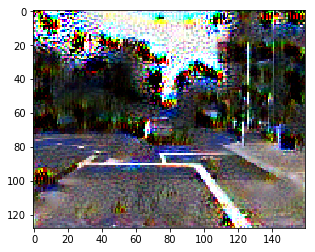

In [331]:
plt.imshow(convert_to_display_format(ascent_gram0,0))

#### this is interesting in that the original image actually didn't get changed too much. I'd like to check the same thing for the highest recurrence layer, but also if we take the methodological parallel to the style transfer a bit further to see whether we can minimize the difference to the gram matrix of the illusion image. To see whether that would be intersting at all it makes sense to check the appearance of some "illusion fingerprint" in the gram matrix.

In [370]:
# define the loss function - which is precisely just the mean of the probability of the given character across the batch
#loss = lambda_2*K.mean(test_model.output[0,:,3]) - lambda_0*K.mean(test_model.output[0,:,0])
loss = -K.sum(K.square(gram_tensor(test_model.output) - gram_tensor(X_ill_errors_3)))

#compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

#normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

#this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [372]:
# run gradient ascent for n steps

#input_img_data = newim2
input_img_data = init_image
n = 50
step = 0.1
for i in range(n):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data = np.add(input_img_data,grads_value * step) #grads_value * step
    # here we add an artificial regularizer boundary...
    #input_img_data = np.minimum(np.maximum(input_img_data,0.),1.)

    print('Current loss value:', loss_value)

Current loss value: -409381.56
Current loss value: -153536.03
Current loss value: -179592.03
Current loss value: -170546.78
Current loss value: -142863.34
Current loss value: -148568.16
Current loss value: -189240.66
Current loss value: -224778.66
Current loss value: -67626.12
Current loss value: -94650.05
Current loss value: -116844.12
Current loss value: -130626.375
Current loss value: -189222.9
Current loss value: -128868.91
Current loss value: -155051.72
Current loss value: -122388.914
Current loss value: -149752.58
Current loss value: -131327.1
Current loss value: -126278.7
Current loss value: -133942.33
Current loss value: -153493.02
Current loss value: -95531.78
Current loss value: -218219.16
Current loss value: -94417.53
Current loss value: -239723.25
Current loss value: -83052.59
Current loss value: -242963.56
Current loss value: -94583.22
Current loss value: -231417.28
Current loss value: -115617.14
Current loss value: -145163.78
Current loss value: -118947.45
Current loss va

In [373]:
ascent_gram1 = input_img_data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


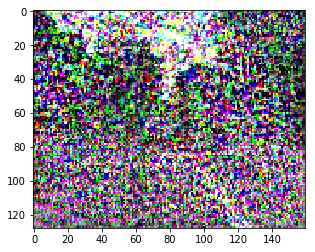

In [374]:
plt.imshow(convert_to_display_format(ascent_gram1,0))

In [375]:
X_street_errors3 = test_model.predict([init_image], batch_size)

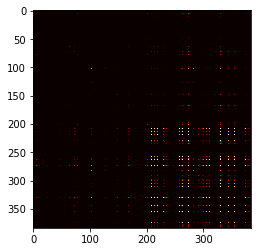

In [376]:
plt.imshow(gram(X_street_errors3), cmap='hot', vmax=4.0)
plt.show()

In [386]:
# define the loss function - which is precisely just the mean of the probability of the given character across the batch
#loss = lambda_2*K.mean(test_model.output[0,:,3]) - lambda_0*K.mean(test_model.output[0,:,0])
lambda_0 = 0.1
frobenius_diff = K.sum(K.square(gram_tensor(test_model.output) - gram_tensor(X_ill_errors_3))) 
frobenius_ill = np.sum(np.square(gram(X_ill_errors_3)))
loss = -frobenius_diff/frobenius_ill - lambda_0*K.mean(K.abs(input_img - init_image))

#compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

#normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

#this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [387]:
# run gradient ascent for n steps

#input_img_data = newim2
input_img_data = init_image
n = 100
step = 0.04
for i in range(n):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data = np.add(input_img_data,grads_value * step) #grads_value * step
    # here we add an artificial regularizer boundary...
    #input_img_data = np.minimum(np.maximum(input_img_data,0.),1.)

    print('Current loss value:', loss_value)

Current loss value: -0.8049415
Current loss value: -0.4941906
Current loss value: -0.19305548
Current loss value: -0.09038137
Current loss value: -0.22346106
Current loss value: -0.07584525
Current loss value: -0.16970438
Current loss value: -0.080754004
Current loss value: -0.16853626
Current loss value: -0.057990715
Current loss value: -0.12803884
Current loss value: -0.081753105
Current loss value: -0.13437095
Current loss value: -0.08091942
Current loss value: -0.1097522
Current loss value: -0.08850021
Current loss value: -0.11106751
Current loss value: -0.07710422
Current loss value: -0.11724034
Current loss value: -0.07519985
Current loss value: -0.114516854
Current loss value: -0.0691609
Current loss value: -0.102641806
Current loss value: -0.07230991
Current loss value: -0.101992175
Current loss value: -0.07515615
Current loss value: -0.09522536
Current loss value: -0.06423998
Current loss value: -0.101120666
Current loss value: -0.062393773
Current loss value: -0.09831526
Curr

In [388]:
ascent_gram2 = input_img_data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


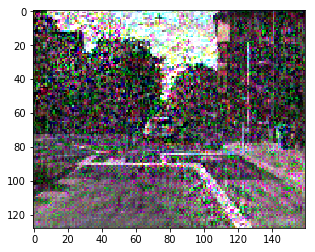

In [389]:
plt.imshow(convert_to_display_format(ascent_gram2,0))